# LSTM track-finding model for 2D detector layers

In this notebook we extend the method of the "simple" LSTM on 1D detector layer data to 2D detector layers, using the data functionality developed in the DataGen2D notebook.

Unlike the simple LSTM ('KF', or Kalman-filter inspired) notebooks, we won't be doing next-layer predictions, but current-layer predictions (or pixel classification scores).

In [3]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Local imports
from models import build_lstm_model, build_deep_lstm_model
from metrics import calc_hit_accuracy

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [4]:
# Set random seed
np.random.seed(2017)

## Utilities

In [5]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, truthx=None, truthy=None, figsize=(12,5)):
    """Draw each detector layer as a grid of images"""
    num_det_layers = event.shape[0]
    nrows = math.ceil(float(num_det_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_det_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
        ax.autoscale(False)
        if truthx is not None and truthy is not None:
            ax.plot(truthx[ilay]-0.5, truthy[ilay]-0.5, 'w+')
    plt.tight_layout()

def draw_train_history(history, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend()
    plt.tight_layout()

def draw_projections(event, truthx=None, truthy=None, figsize=(12,5)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    kwargs = dict(interpolation='none',
                  aspect='auto',
                  origin='lower')
    plt.imshow(event.sum(axis=1).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.autoscale(False)
    if truthy is not None:
        plt.plot(np.arange(event.shape[0]-0.5), truthy-0.5, 'w-')
    plt.subplot(122)
    plt.imshow(event.sum(axis=2).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.tight_layout()
    plt.autoscale(False)
    if truthx is not None:
        plt.plot(np.arange(event.shape[0]-0.5), truthx-0.5, 'w-')

In [6]:
def gen_noise(shape, prob=0.1, seed_layers=0):
    noise = (np.random.random_sample(shape) < prob).astype(np.int8)
    noise[:,:seed_layers,:,:] = 0
    return noise

def sample_track_params(n, num_det_layers, det_layer_size):
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, det_layer_size, size=(n, 2))    
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_det_layers - 1)
    return np.concatenate([slopes, entry_points], axis=1)

def track_hit_coords(params, det_layer_idx, as_type=np.int):
    xslope, yslope, xentry, yentry = params
    xhits = xslope*det_layer_idx + xentry
    yhits = yslope*det_layer_idx + yentry
    return xhits.astype(as_type), yhits.astype(as_type)
    
def gen_straight_tracks(n, num_det_layers, det_layer_size):
    # Initialize the data
    data = np.zeros((n, num_det_layers, det_layer_size, det_layer_size),
                    dtype=np.float32)
    # Sample track parameters
    params = sample_track_params(n, num_det_layers, det_layer_size)
    # Calculate hit positions and fill hit data
    idx = np.arange(num_det_layers)
    for ievt in range(n):
        xhits, yhits = track_hit_coords(params[ievt], idx)
        data[ievt,idx,xhits,yhits] = 1   
    return data, params

def gen_bkg_tracks(num_event, num_det_layers, det_layer_size,
                   avg_bkg_tracks=3, seed_layers=0):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_det_layers, det_layer_size, det_layer_size),
                          dtype=np.float32)
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks(ntrk, num_det_layers, det_layer_size)[0])
    bkg_tracks[:,:seed_layers,:,:] = 0
    return bkg_tracks

In [7]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

## Configuration

In [8]:
num_event = 102400
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
avg_bkg_tracks = 3
noise_prob = 0.01
shape = (num_event, num_det_layers, det_layer_size, det_layer_size)
det_shape = shape[1:]

## Data generation

In [9]:
def generate_data(shape, num_seed_layers=3, avg_bkg_tracks=3,
                  noise_prob=0.01, verbose=True):
    """
    Top level function to generate a dataset.
    TODO: finish documentation.
    """
    num_event, num_det_layers, det_layer_size, _ = shape
    # Signal tracks
    sig_tracks, sig_params = gen_straight_tracks(
        num_event, num_det_layers, det_layer_size)
    # Background tracks
    bkg_tracks = gen_bkg_tracks(
        num_event, num_det_layers, det_layer_size,
        avg_bkg_tracks=avg_bkg_tracks, seed_layers=num_seed_layers)
    # Noise
    noise = gen_noise(shape, prob=noise_prob, seed_layers=num_seed_layers)
    # Full events
    events = sig_tracks + bkg_tracks + noise
    events[events > 1] = 1
    # Print data sizes
    if verbose:
        print('Sizes of arrays')
        print('  events:     %g MB' % (events.dtype.itemsize * events.size / 1e6))
        print('  sig_tracks: %g MB' % (sig_tracks.dtype.itemsize * sig_tracks.size / 1e6))
        print('  bkg_tracks: %g MB' % (bkg_tracks.dtype.itemsize * bkg_tracks.size / 1e6))
        print('  noise:      %g MB' % (noise.dtype.itemsize * noise.size / 1e6))
    
    return events, sig_tracks, sig_params

In [10]:
# Generate all data
events, sig_tracks, sig_params = generate_data(shape, num_seed_layers=num_seed_layers)

Sizes of arrays
  events:     4194.3 MB
  sig_tracks: 4194.3 MB
  bkg_tracks: 4194.3 MB
  noise:      1048.58 MB


<IPython.core.display.Javascript object>


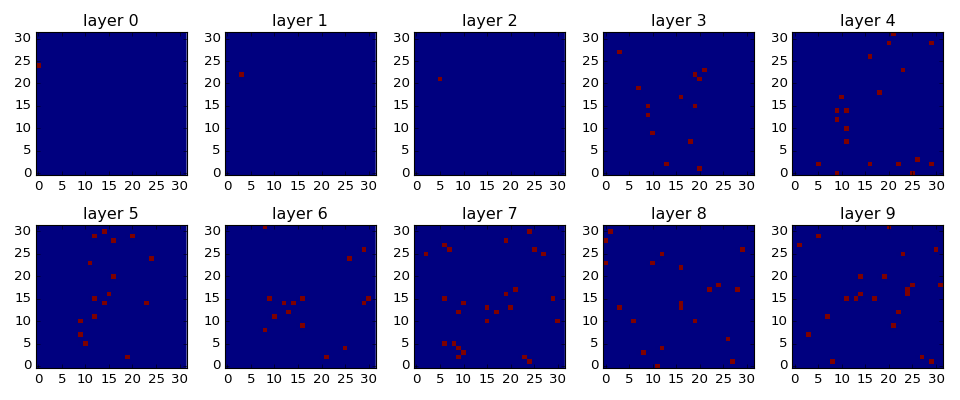

In [11]:
# Visualize one event
draw_layers(events[0])

## Training

In [17]:
# Configure the training
hidden_dim = 1024
batch_size = 256
l2reg = 0.001
dropout = 0.2
num_epoch = 30
valid_frac = 0.2

train_input = flatten_layers(events)
train_target = flatten_layers(sig_tracks)

In [18]:
# Build the model
model = build_deep_lstm_model(num_det_layers, det_layer_size**2,
                              l2reg=l2reg, dropout=dropout,
                              hidden_dim=hidden_dim)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 10, 1024)      0                                            
____________________________________________________________________________________________________
timedistributed_7 (TimeDistribute(None, 10, 1024)      1049600     input_3[0][0]                    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 10, 1024)      8392704     timedistributed_7[0][0]          
____________________________________________________________________________________________________
timedistributed_8 (TimeDistribute(None, 10, 1024)      1049600     lstm_3[0][0]                     
___________________________________________________________________________________________

In [19]:
# Train the model
history = model.fit(train_input, train_target,
                    batch_size=batch_size, nb_epoch=num_epoch,
                    validation_split=valid_frac)

Train on 81920 samples, validate on 20480 samples
Epoch 1/30
81920/81920 [==============================] - 40s - loss: 6.7376 - acc: 0.0029 - val_loss: 6.0908 - val_acc: 0.0053
Epoch 2/30
81920/81920 [==============================] - 38s - loss: 6.0882 - acc: 0.0099 - val_loss: 5.3500 - val_acc: 0.0230
Epoch 3/30
81920/81920 [==============================] - 38s - loss: 5.2359 - acc: 0.0902 - val_loss: 3.7106 - val_acc: 0.1888
Epoch 4/30
81920/81920 [==============================] - 38s - loss: 4.2070 - acc: 0.2518 - val_loss: 2.8755 - val_acc: 0.3196
Epoch 5/30
81920/81920 [==============================] - 38s - loss: 3.7688 - acc: 0.3343 - val_loss: 2.6095 - val_acc: 0.3637
Epoch 6/30
81920/81920 [==============================] - 38s - loss: 3.5707 - acc: 0.3680 - val_loss: 2.4437 - val_acc: 0.3912
Epoch 7/30
81920/81920 [==============================] - 38s - loss: 3.4169 - acc: 0.3935 - val_loss: 2.3199 - val_acc: 0.4117
Epoch 8/30
81920/81920 [==============================

<IPython.core.display.Javascript object>


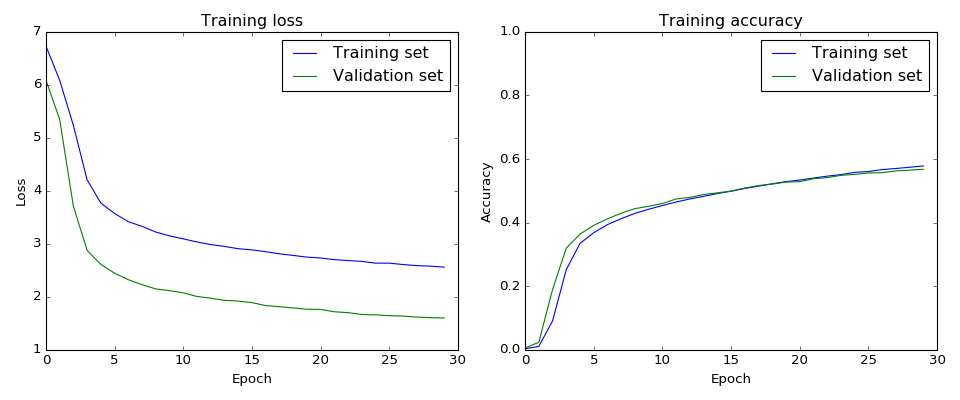

In [20]:
draw_train_history(history)

## Evaluate results

### Training + validation set

In [ ]:
# Get all of the training data predictions
train_preds = model.predict(train_input, batch_size=batch_size)

In [32]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(train_preds, train_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
scores = train_preds * flatten_layers(events)
hit_accuracy = calc_hit_accuracy(scores, train_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.45136997767857145
Accuracy of classified hit:  0.948234375


Input data for event:


<IPython.core.display.Javascript object>


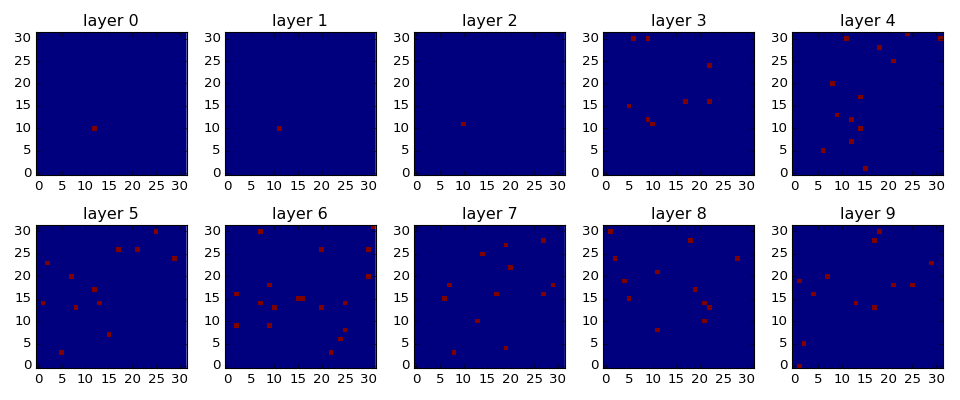

Model prediction:


<IPython.core.display.Javascript object>


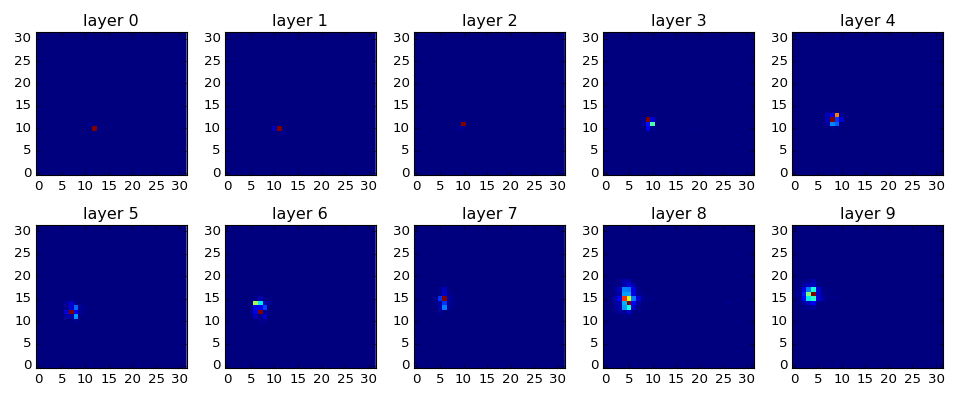

Projected input data


<IPython.core.display.Javascript object>


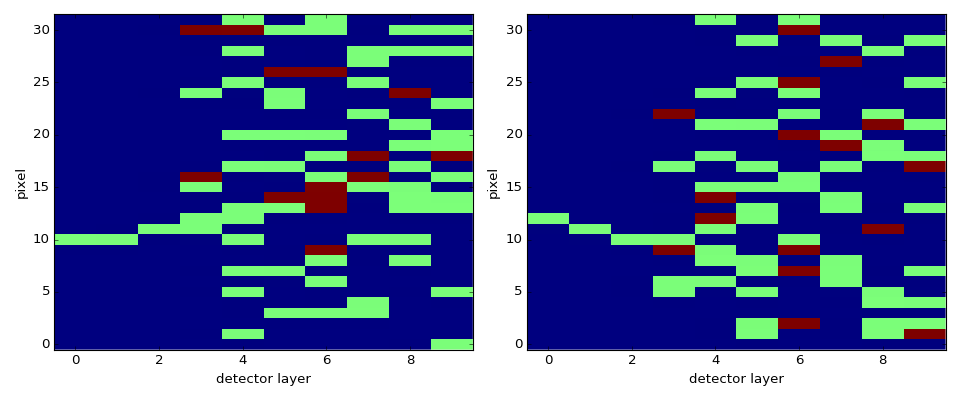

Projected model prediction


<IPython.core.display.Javascript object>


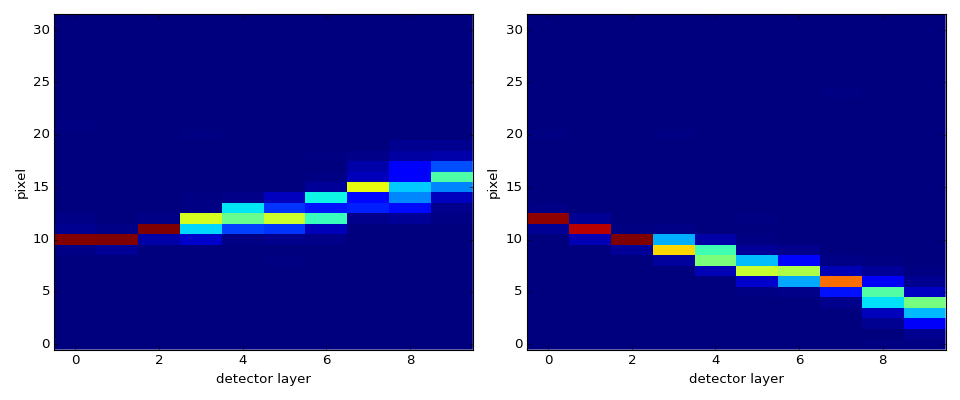

In [33]:
# Visualize one event
disp_idx = 6
print('Input data for event:')
draw_layers(events[disp_idx], figsize=(12,5))
print('Model prediction:')
pred = train_preds[disp_idx].reshape(det_shape)
draw_layers(pred, figsize=(12,5))

# Draw the 2D projections
print('Projected input data')
draw_projections(events[disp_idx])
print('Projected model prediction')
draw_projections(pred)

In [34]:
# Clean up if needed
del sig_tracks, events, scores, train_input, train_target, train_preds

### Test set

In [38]:
# Generate a new test dataset
test_num_event = 25600
test_events, test_sigtrks, test_sigparams = generate_data((test_num_event,) + det_shape)
test_input = flatten_layers(test_events)
test_target = flatten_layers(test_sigtrks)
test_preds = model.predict(test_input, batch_size=batch_size)

Sizes of arrays
  events:     1048.58 MB
  sig_tracks: 1048.58 MB
  bkg_tracks: 1048.58 MB
  noise:      262.144 MB


In [39]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * flatten_layers(test_events)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.3839174107142857
Accuracy of classified hit:  0.93023046875


Input data example event:


<IPython.core.display.Javascript object>


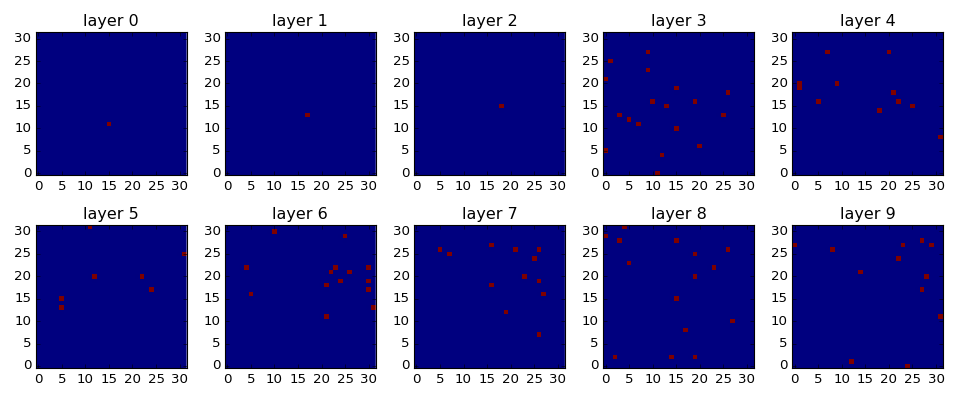

Model prediction:


<IPython.core.display.Javascript object>


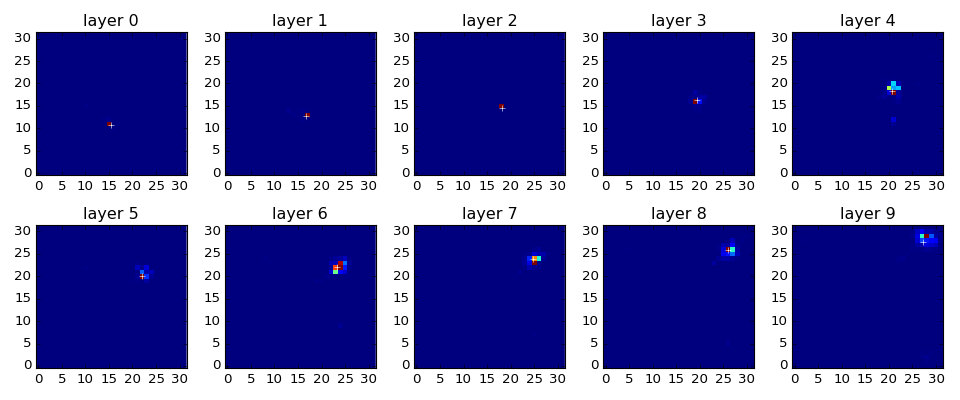

Projected input data:


<IPython.core.display.Javascript object>


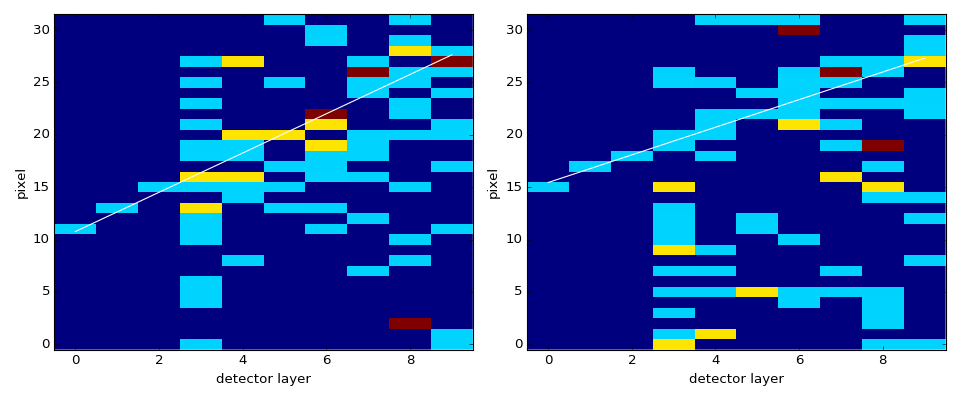

Projected model prediction:


<IPython.core.display.Javascript object>


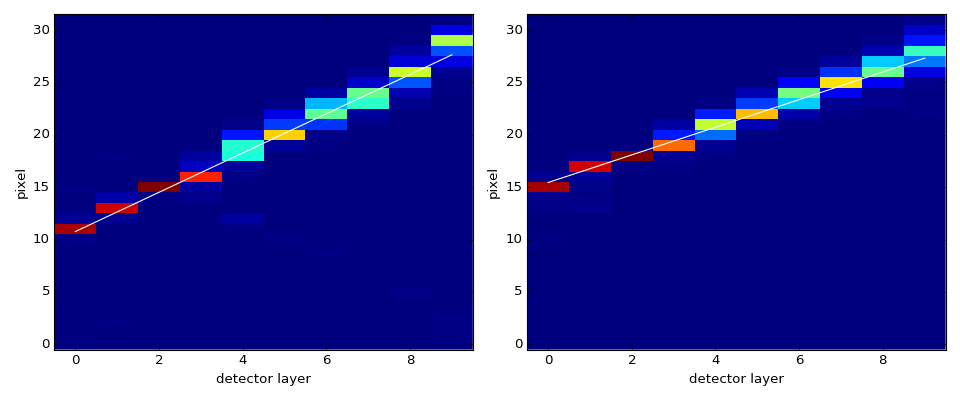

In [42]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
                                  idx, as_type=np.float32)

# Draw the layers
print('Input data example event:')
draw_layers(test_events[disp_idx])
print('Model prediction:')
draw_layers(test_preds[disp_idx].reshape(det_shape),
            truthx=xtruth, truthy=ytruth)
print('Projected input data:')
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
print('Projected model prediction:')
draw_projections(test_preds[disp_idx].reshape(det_shape),
                 truthx=xtruth, truthy=ytruth)

## Conclusion

Utilizing current-layer predictions rather than next-layer predictions seems to work well.
In fact I see no reason to continue doing next-layer predictions despite some philosophical connection to Kalman Filter techniques.

The test set accuracy of classifying hits is >90%.

Good regularization was essential to avoid overfitting in this case.